In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, auc, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# plotting
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import datetime

# setup
import os
os.chdir("/Users/adesai/mcadoo-failures-master/")
import glob
import feather
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import tsfresh
from tsfresh import extract_features
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters

In [2]:
failures = pd.read_csv("failures.csv", index_col=0)
failures.head()

,Site,ID,Distance.to.turbine.south,Distance.to.turbine.north,Distance.to.terrain.feature.south,Distance.to.terrain.feature.north,Component.Manufacturer,Oil.Grease.Type,Failure,Individual.Damaged.Components,Starting.Date,Shutdown.Date,Operating.Hours.Before.Failure,Wallclock.Minutes.Before.Failure
1,McAdoo,1,35,35,1670,750,Moventas,Castrol A 320,no,na,7/2/08,NaN,24,NaN
2,McAdoo,2,35,35,1720,1020,Winergy,Castrol A 320,yes,HSS Bearing A,7/2/08,2/20/12,11,1912380.0
3,McAdoo,3,35,35,1700,1050,Winergy,Castrol A 320,no,na,7/2/08,NaN,24,NaN
4,McAdoo,4,35,36,2450,1160,Moventas,Castrol A 320,yes,HSS Bearing A,7/2/08,2/10/12,10,1897980.0
5,McAdoo,4,35,36,2450,1160,Moventas,Castrol X 320,yes,HSS Bearing A,2/10/12,4/29/13,2,639300.0


### Function to prepare data

In [4]:
cols = ['Turbine_ID', 'Date', 'A_Load_N_mean_hss', 'A_Energy_J_mean_hss', 'B_Energy_J_mean_hss',
 'Shaft_Speed_rpm_mean_hss', 'A_SlipDensity_mean_hss', 'B_SlipDensity_mean_hss', 'A_SRR_max_mean_hss', 
 'A_Energy_J_mean_ims', 'B_Energy_J_mean_ims', 'A_SlipDensity_mean_ims','B_SlipDensity_mean_ims',
 'A_Load_N_sd_hss', 'A_Energy_J_sd_hss', 'B_Energy_J_sd_hss',
 'Shaft_Speed_rpm_sd_hss', 'A_SlipDensity_sd_hss', 'B_SlipDensity_sd_hss', 'A_SRR_max_sd_hss', 
 'A_Energy_J_sd_ims', 'B_Energy_J_sd_ims', 'A_SlipDensity_sd_ims','B_SlipDensity_sd_ims',
 'A_Load_N_min_hss', 'A_Energy_J_min_hss', 'B_Energy_J_min_hss',
 'Shaft_Speed_rpm_min_hss', 'A_SlipDensity_min_hss', 'B_SlipDensity_min_hss', 'A_SRR_max_min_hss', 
 'A_Energy_J_min_ims', 'B_Energy_J_min_ims', 'A_SlipDensity_min_ims','B_SlipDensity_min_ims',
 'A_Load_N_max_hss', 'A_Energy_J_max_hss', 'B_Energy_J_max_hss',
 'Shaft_Speed_rpm_max_hss', 'A_SlipDensity_max_hss', 'B_SlipDensity_max_hss', 'A_SRR_max_max_hss', 
 'A_Energy_J_max_ims', 'B_Energy_J_max_ims', 'A_SlipDensity_max_ims','B_SlipDensity_max_ims',
 'A_Load_N_rms_hss', 'A_Energy_J_rms_hss', 'B_Energy_J_rms_hss',
 'Shaft_Speed_rpm_rms_hss', 'A_SlipDensity_rms_hss', 'B_SlipDensity_rms_hss', 'A_SRR_max_rms_hss', 
 'A_Energy_J_rms_ims', 'B_Energy_J_rms_ims', 'A_SlipDensity_rms_ims','B_SlipDensity_rms_ims',
 'A_Load_N_kurtosis_hss', 'A_Energy_J_kurtosis_hss', 'B_Energy_J_kurtosis_hss',
 'Shaft_Speed_rpm_kurtosis_hss', 'A_SlipDensity_kurtosis_hss', 'B_SlipDensity_kurtosis_hss', 'A_SRR_max_kurtosis_hss', 
 'A_Energy_J_kurtosis_ims', 'B_Energy_J_kurtosis_ims', 'A_SlipDensity_kurtosis_ims','B_SlipDensity_kurtosis_ims']

In [5]:
def prep_df(turbine_ids, date, failed_ids):
    
    failure = pd.DataFrame(columns = ['turbine_id', 'failed'])
    df = pd.DataFrame()

    for i in turbine_ids:
        temp_df = feather.read_dataframe(glob.glob("Datafeathers/nondimensionalized/*_" + str(i) + "_*.feather")[0])
        temp_df.Date = pd.to_datetime(temp_df.Date)
                        
        if i in failed_ids:
            
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
            
            if(pd.notnull(shutdown_date)):
                temp_df = temp_df[temp_df.Date <= shutdown_date]
                start_date = shutdown_date - pd.to_timedelta(90, unit='d')
                temp_df = temp_df[temp_df.Date >= start_date]
                failure = failure.append({'turbine_id': i, 'failed':1}, True)
        
        else: 
            
            last_date = pd.to_datetime(date)
            temp_df = temp_df[temp_df.Date <= last_date] #"10-01-2013"
            start_date = last_date - pd.to_timedelta(90, unit='d')
            temp_df = temp_df[temp_df.Date >= start_date]
            failure = failure.append({'turbine_id': i, 'failed':0}, True)
            
        df = df.append(temp_df)

    df = df.reset_index(drop = True)

    df = df[cols]
    
    failure = failure.sort_values('turbine_id').reset_index(drop = True)
    df.dropna(inplace = True)
    return df, failure

### Dictionary of all Tsfresh features

In [6]:
tsfeats = {
 'variance_larger_than_standard_deviation': None,  # if varince is greater than std.deviation i.e sqrt(variance)
 'abs_energy': None, # the sum over the squared values
 'mean_abs_change': None, # mean of abs difference between subsequent time series values ~ lag 1
 'mean_change': None, # difference bw first and last value
 'mean_second_derivative_central': None, # mean value of a central approximation of the second derivative
 'median': None, # median
 'mean': None, # mean
 'standard_deviation': None, # std
 'variance': None, # variance
 'skewness': None, # skewness
 'kurtosis': None, # kurtosis
 'absolute_sum_of_changes': None, # sum of abs difference between subsequent time series values ~ lag 1
 'longest_strike_below_mean': None, # length of the longest consecutive subsequence in x that is smaller than the mean of x
 'longest_strike_above_mean': None, # length of the longest consecutive subsequence in x that is bigger than the mean of x
 'count_above_mean': None, # above mean counts
 'count_below_mean': None, # below mean counts
 'last_location_of_maximum': None, 
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'maximum': None,
 'minimum': None,
 'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'cid_ce': [{'normalize': True}, {'normalize': False}],   
 'symmetry_looking': [{'r': 0.0},
  {'r': 0.1},
  {'r': 0.2},
  {'r': 0.3},
  {'r': 0.4},
  {'r': 0.5},
  {'r': 0.6},
  {'r': 0.7},
  {'r': 0.8},
  {'r': 0.9}],
 'large_standard_deviation': [{'r': 0.1},
  {'r': 0.2},
  {'r': 0.3},
  {'r': 0.4},
  {'r': 0.5},
  {'r': 0.6},
  {'r': 0.7},
  {'r': 0.8},
  {'r': 0.9}],
 'quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'autocorrelation': [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 5},
  {'lag': 6},
  {'lag': 7},
  {'lag': 8},
  {'lag': 9}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
  {'f_agg': 'median', 'maxlag': 40},
  {'f_agg': 'var', 'maxlag': 40}],
 'partial_autocorrelation': [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 5},
  {'lag': 6},
  {'lag': 7},
  {'lag': 8},
  {'lag': 9}],
 'number_cwt_peaks': [{'n': 1}, {'n': 5}],
 'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}, {'n': 10}, {'n': 50}],
 'binned_entropy': [{'max_bins': 10}],
 'index_mass_quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'change_quantiles': [{'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'}],
 'friedrich_coefficients': [{'coeff': 0, 'm': 3, 'r': 30},
  {'coeff': 1, 'm': 3, 'r': 30},
  {'coeff': 2, 'm': 3, 'r': 30},
  {'coeff': 3, 'm': 3, 'r': 30}],
 'max_langevin_fixed_point': [{'m': 3, 'r': 30}],
 'agg_linear_trend': [{'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'var'}],
 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0},
  {'num_segments': 10, 'segment_focus': 1},
  {'num_segments': 10, 'segment_focus': 2},
  {'num_segments': 10, 'segment_focus': 3},
  {'num_segments': 10, 'segment_focus': 4},
  {'num_segments': 10, 'segment_focus': 5},
  {'num_segments': 10, 'segment_focus': 6},
  {'num_segments': 10, 'segment_focus': 7},
  {'num_segments': 10, 'segment_focus': 8},
  {'num_segments': 10, 'segment_focus': 9}],
 'ratio_beyond_r_sigma': [{'r': 0.5},
  {'r': 1},
  {'r': 1.5},
  {'r': 2},
  {'r': 2.5},
  {'r': 3},
  {'r': 5},
  {'r': 6},
  {'r': 7},
  {'r': 10}],
 'fft_coefficient': [{'coeff': 0, 'attr': 'real'},
  {'coeff': 1, 'attr': 'real'},
  {'coeff': 2, 'attr': 'real'},
  {'coeff': 3, 'attr': 'real'},
  {'coeff': 4, 'attr': 'real'},
  {'coeff': 5, 'attr': 'real'},
  {'coeff': 6, 'attr': 'real'},
  {'coeff': 7, 'attr': 'real'},
  {'coeff': 8, 'attr': 'real'},
  {'coeff': 9, 'attr': 'real'},
  {'coeff': 10, 'attr': 'real'},
  {'coeff': 11, 'attr': 'real'},
  {'coeff': 12, 'attr': 'real'},
  {'coeff': 13, 'attr': 'real'},
  {'coeff': 14, 'attr': 'real'},
  {'coeff': 15, 'attr': 'real'},
  {'coeff': 16, 'attr': 'real'},
  {'coeff': 17, 'attr': 'real'},
  {'coeff': 18, 'attr': 'real'},
  {'coeff': 19, 'attr': 'real'},
  {'coeff': 20, 'attr': 'real'},
  {'coeff': 21, 'attr': 'real'},
  {'coeff': 22, 'attr': 'real'},
  {'coeff': 23, 'attr': 'real'},
  {'coeff': 24, 'attr': 'real'},
  {'coeff': 25, 'attr': 'real'},
  {'coeff': 26, 'attr': 'real'},
  {'coeff': 27, 'attr': 'real'},
  {'coeff': 28, 'attr': 'real'},
  {'coeff': 29, 'attr': 'real'},
  {'coeff': 30, 'attr': 'real'},
  {'coeff': 31, 'attr': 'real'},
  {'coeff': 32, 'attr': 'real'},
  {'coeff': 33, 'attr': 'real'},
  {'coeff': 34, 'attr': 'real'},
  {'coeff': 35, 'attr': 'real'},
  {'coeff': 36, 'attr': 'real'},
  {'coeff': 37, 'attr': 'real'},
  {'coeff': 38, 'attr': 'real'},
  {'coeff': 39, 'attr': 'real'},
  {'coeff': 40, 'attr': 'real'},
  {'coeff': 41, 'attr': 'real'},
  {'coeff': 42, 'attr': 'real'},
  {'coeff': 43, 'attr': 'real'},
  {'coeff': 44, 'attr': 'real'},
  {'coeff': 45, 'attr': 'real'},
  {'coeff': 46, 'attr': 'real'},
  {'coeff': 47, 'attr': 'real'},
  {'coeff': 48, 'attr': 'real'},
  {'coeff': 49, 'attr': 'real'},
  {'coeff': 50, 'attr': 'real'},
  {'coeff': 51, 'attr': 'real'},
  {'coeff': 52, 'attr': 'real'},
  {'coeff': 53, 'attr': 'real'},
  {'coeff': 54, 'attr': 'real'},
  {'coeff': 55, 'attr': 'real'},
  {'coeff': 56, 'attr': 'real'},
  {'coeff': 57, 'attr': 'real'},
  {'coeff': 58, 'attr': 'real'},
  {'coeff': 59, 'attr': 'real'},
  {'coeff': 60, 'attr': 'real'},
  {'coeff': 61, 'attr': 'real'},
  {'coeff': 62, 'attr': 'real'},
  {'coeff': 63, 'attr': 'real'},
  {'coeff': 64, 'attr': 'real'},
  {'coeff': 65, 'attr': 'real'},
  {'coeff': 66, 'attr': 'real'},
  {'coeff': 67, 'attr': 'real'},
  {'coeff': 68, 'attr': 'real'},
  {'coeff': 69, 'attr': 'real'},
  {'coeff': 70, 'attr': 'real'},
  {'coeff': 71, 'attr': 'real'},
  {'coeff': 72, 'attr': 'real'},
  {'coeff': 73, 'attr': 'real'},
  {'coeff': 74, 'attr': 'real'},
  {'coeff': 75, 'attr': 'real'},
  {'coeff': 76, 'attr': 'real'},
  {'coeff': 77, 'attr': 'real'},
  {'coeff': 78, 'attr': 'real'},
  {'coeff': 79, 'attr': 'real'},
  {'coeff': 80, 'attr': 'real'},
  {'coeff': 81, 'attr': 'real'},
  {'coeff': 82, 'attr': 'real'},
  {'coeff': 83, 'attr': 'real'},
  {'coeff': 84, 'attr': 'real'},
  {'coeff': 85, 'attr': 'real'},
  {'coeff': 86, 'attr': 'real'},
  {'coeff': 87, 'attr': 'real'},
  {'coeff': 88, 'attr': 'real'},
  {'coeff': 89, 'attr': 'real'},
  {'coeff': 90, 'attr': 'real'},
  {'coeff': 91, 'attr': 'real'},
  {'coeff': 92, 'attr': 'real'},
  {'coeff': 93, 'attr': 'real'},
  {'coeff': 94, 'attr': 'real'},
  {'coeff': 95, 'attr': 'real'},
  {'coeff': 96, 'attr': 'real'},
  {'coeff': 97, 'attr': 'real'},
  {'coeff': 98, 'attr': 'real'},
  {'coeff': 99, 'attr': 'real'},
  {'coeff': 0, 'attr': 'imag'},
  {'coeff': 1, 'attr': 'imag'},
  {'coeff': 2, 'attr': 'imag'},
  {'coeff': 3, 'attr': 'imag'},
  {'coeff': 4, 'attr': 'imag'},
  {'coeff': 5, 'attr': 'imag'},
  {'coeff': 6, 'attr': 'imag'},
  {'coeff': 7, 'attr': 'imag'},
  {'coeff': 8, 'attr': 'imag'},
  {'coeff': 9, 'attr': 'imag'},
  {'coeff': 10, 'attr': 'imag'},
  {'coeff': 11, 'attr': 'imag'},
  {'coeff': 12, 'attr': 'imag'},
  {'coeff': 13, 'attr': 'imag'},
  {'coeff': 14, 'attr': 'imag'},
  {'coeff': 15, 'attr': 'imag'},
  {'coeff': 16, 'attr': 'imag'},
  {'coeff': 17, 'attr': 'imag'},
  {'coeff': 18, 'attr': 'imag'},
  {'coeff': 19, 'attr': 'imag'},
  {'coeff': 20, 'attr': 'imag'},
  {'coeff': 21, 'attr': 'imag'},
  {'coeff': 22, 'attr': 'imag'},
  {'coeff': 23, 'attr': 'imag'},
  {'coeff': 24, 'attr': 'imag'},
  {'coeff': 25, 'attr': 'imag'},
  {'coeff': 26, 'attr': 'imag'},
  {'coeff': 27, 'attr': 'imag'},
  {'coeff': 28, 'attr': 'imag'},
  {'coeff': 29, 'attr': 'imag'},
  {'coeff': 30, 'attr': 'imag'},
  {'coeff': 31, 'attr': 'imag'},
  {'coeff': 32, 'attr': 'imag'},
  {'coeff': 33, 'attr': 'imag'},
  {'coeff': 34, 'attr': 'imag'},
  {'coeff': 35, 'attr': 'imag'},
  {'coeff': 36, 'attr': 'imag'},
  {'coeff': 37, 'attr': 'imag'},
  {'coeff': 38, 'attr': 'imag'},
  {'coeff': 39, 'attr': 'imag'},
  {'coeff': 40, 'attr': 'imag'},
  {'coeff': 41, 'attr': 'imag'},
  {'coeff': 42, 'attr': 'imag'},
  {'coeff': 43, 'attr': 'imag'},
  {'coeff': 44, 'attr': 'imag'},
  {'coeff': 45, 'attr': 'imag'},
  {'coeff': 46, 'attr': 'imag'},
  {'coeff': 47, 'attr': 'imag'},
  {'coeff': 48, 'attr': 'imag'},
  {'coeff': 49, 'attr': 'imag'},
  {'coeff': 50, 'attr': 'imag'},
  {'coeff': 51, 'attr': 'imag'},
  {'coeff': 52, 'attr': 'imag'},
  {'coeff': 53, 'attr': 'imag'},
  {'coeff': 54, 'attr': 'imag'},
  {'coeff': 55, 'attr': 'imag'},
  {'coeff': 56, 'attr': 'imag'},
  {'coeff': 57, 'attr': 'imag'},
  {'coeff': 58, 'attr': 'imag'},
  {'coeff': 59, 'attr': 'imag'},
  {'coeff': 60, 'attr': 'imag'},
  {'coeff': 61, 'attr': 'imag'},
  {'coeff': 62, 'attr': 'imag'},
  {'coeff': 63, 'attr': 'imag'},
  {'coeff': 64, 'attr': 'imag'},
  {'coeff': 65, 'attr': 'imag'},
  {'coeff': 66, 'attr': 'imag'},
  {'coeff': 67, 'attr': 'imag'},
  {'coeff': 68, 'attr': 'imag'},
  {'coeff': 69, 'attr': 'imag'},
  {'coeff': 70, 'attr': 'imag'},
  {'coeff': 71, 'attr': 'imag'},
  {'coeff': 72, 'attr': 'imag'},
  {'coeff': 73, 'attr': 'imag'},
  {'coeff': 74, 'attr': 'imag'},
  {'coeff': 75, 'attr': 'imag'},
  {'coeff': 76, 'attr': 'imag'},
  {'coeff': 77, 'attr': 'imag'},
  {'coeff': 78, 'attr': 'imag'},
  {'coeff': 79, 'attr': 'imag'},
  {'coeff': 80, 'attr': 'imag'},
  {'coeff': 81, 'attr': 'imag'},
  {'coeff': 82, 'attr': 'imag'},
  {'coeff': 83, 'attr': 'imag'},
  {'coeff': 84, 'attr': 'imag'},
  {'coeff': 85, 'attr': 'imag'},
  {'coeff': 86, 'attr': 'imag'},
  {'coeff': 87, 'attr': 'imag'},
  {'coeff': 88, 'attr': 'imag'},
  {'coeff': 89, 'attr': 'imag'},
  {'coeff': 90, 'attr': 'imag'},
  {'coeff': 91, 'attr': 'imag'},
  {'coeff': 92, 'attr': 'imag'},
  {'coeff': 93, 'attr': 'imag'},
  {'coeff': 94, 'attr': 'imag'},
  {'coeff': 95, 'attr': 'imag'},
  {'coeff': 96, 'attr': 'imag'},
  {'coeff': 97, 'attr': 'imag'},
  {'coeff': 98, 'attr': 'imag'},
  {'coeff': 99, 'attr': 'imag'},
  {'coeff': 0, 'attr': 'abs'},
  {'coeff': 1, 'attr': 'abs'},
  {'coeff': 2, 'attr': 'abs'},
  {'coeff': 3, 'attr': 'abs'},
  {'coeff': 4, 'attr': 'abs'},
  {'coeff': 5, 'attr': 'abs'},
  {'coeff': 6, 'attr': 'abs'},
  {'coeff': 7, 'attr': 'abs'},
  {'coeff': 8, 'attr': 'abs'},
  {'coeff': 9, 'attr': 'abs'},
  {'coeff': 10, 'attr': 'abs'},
  {'coeff': 11, 'attr': 'abs'},
  {'coeff': 12, 'attr': 'abs'},
  {'coeff': 13, 'attr': 'abs'},
  {'coeff': 14, 'attr': 'abs'},
  {'coeff': 15, 'attr': 'abs'},
  {'coeff': 16, 'attr': 'abs'},
  {'coeff': 17, 'attr': 'abs'},
  {'coeff': 18, 'attr': 'abs'},
  {'coeff': 19, 'attr': 'abs'},
  {'coeff': 20, 'attr': 'abs'},
  {'coeff': 21, 'attr': 'abs'},
  {'coeff': 22, 'attr': 'abs'},
  {'coeff': 23, 'attr': 'abs'},
  {'coeff': 24, 'attr': 'abs'},
  {'coeff': 25, 'attr': 'abs'},
  {'coeff': 26, 'attr': 'abs'},
  {'coeff': 27, 'attr': 'abs'},
  {'coeff': 28, 'attr': 'abs'},
  {'coeff': 29, 'attr': 'abs'},
  {'coeff': 30, 'attr': 'abs'},
  {'coeff': 31, 'attr': 'abs'},
  {'coeff': 32, 'attr': 'abs'},
  {'coeff': 33, 'attr': 'abs'},
  {'coeff': 34, 'attr': 'abs'},
  {'coeff': 35, 'attr': 'abs'},
  {'coeff': 36, 'attr': 'abs'},
  {'coeff': 37, 'attr': 'abs'},
  {'coeff': 38, 'attr': 'abs'},
  {'coeff': 39, 'attr': 'abs'},
  {'coeff': 40, 'attr': 'abs'},
  {'coeff': 41, 'attr': 'abs'},
  {'coeff': 42, 'attr': 'abs'},
  {'coeff': 43, 'attr': 'abs'},
  {'coeff': 44, 'attr': 'abs'},
  {'coeff': 45, 'attr': 'abs'},
  {'coeff': 46, 'attr': 'abs'},
  {'coeff': 47, 'attr': 'abs'},
  {'coeff': 48, 'attr': 'abs'},
  {'coeff': 49, 'attr': 'abs'},
  {'coeff': 50, 'attr': 'abs'},
  {'coeff': 51, 'attr': 'abs'},
  {'coeff': 52, 'attr': 'abs'},
  {'coeff': 53, 'attr': 'abs'},
  {'coeff': 54, 'attr': 'abs'},
  {'coeff': 55, 'attr': 'abs'},
  {'coeff': 56, 'attr': 'abs'},
  {'coeff': 57, 'attr': 'abs'},
  {'coeff': 58, 'attr': 'abs'},
  {'coeff': 59, 'attr': 'abs'},
  {'coeff': 60, 'attr': 'abs'},
  {'coeff': 61, 'attr': 'abs'},
  {'coeff': 62, 'attr': 'abs'},
  {'coeff': 63, 'attr': 'abs'},
  {'coeff': 64, 'attr': 'abs'},
  {'coeff': 65, 'attr': 'abs'},
  {'coeff': 66, 'attr': 'abs'},
  {'coeff': 67, 'attr': 'abs'},
  {'coeff': 68, 'attr': 'abs'},
  {'coeff': 69, 'attr': 'abs'},
  {'coeff': 70, 'attr': 'abs'},
  {'coeff': 71, 'attr': 'abs'},
  {'coeff': 72, 'attr': 'abs'},
  {'coeff': 73, 'attr': 'abs'},
  {'coeff': 74, 'attr': 'abs'},
  {'coeff': 75, 'attr': 'abs'},
  {'coeff': 76, 'attr': 'abs'},
  {'coeff': 77, 'attr': 'abs'},
  {'coeff': 78, 'attr': 'abs'},
  {'coeff': 79, 'attr': 'abs'},
  {'coeff': 80, 'attr': 'abs'},
  {'coeff': 81, 'attr': 'abs'},
  {'coeff': 82, 'attr': 'abs'},
  {'coeff': 83, 'attr': 'abs'},
  {'coeff': 84, 'attr': 'abs'},
  {'coeff': 85, 'attr': 'abs'},
  {'coeff': 86, 'attr': 'abs'},
  {'coeff': 87, 'attr': 'abs'},
  {'coeff': 88, 'attr': 'abs'},
  {'coeff': 89, 'attr': 'abs'},
  {'coeff': 90, 'attr': 'abs'},
  {'coeff': 91, 'attr': 'abs'},
  {'coeff': 92, 'attr': 'abs'},
  {'coeff': 93, 'attr': 'abs'},
  {'coeff': 94, 'attr': 'abs'},
  {'coeff': 95, 'attr': 'abs'},
  {'coeff': 96, 'attr': 'abs'},
  {'coeff': 97, 'attr': 'abs'},
  {'coeff': 98, 'attr': 'abs'},
  {'coeff': 99, 'attr': 'abs'},
  {'coeff': 0, 'attr': 'angle'},
  {'coeff': 1, 'attr': 'angle'},
  {'coeff': 2, 'attr': 'angle'},
  {'coeff': 3, 'attr': 'angle'},
  {'coeff': 4, 'attr': 'angle'},
  {'coeff': 5, 'attr': 'angle'},
  {'coeff': 6, 'attr': 'angle'},
  {'coeff': 7, 'attr': 'angle'},
  {'coeff': 8, 'attr': 'angle'},
  {'coeff': 9, 'attr': 'angle'},
  {'coeff': 10, 'attr': 'angle'},
  {'coeff': 11, 'attr': 'angle'},
  {'coeff': 12, 'attr': 'angle'},
  {'coeff': 13, 'attr': 'angle'},
  {'coeff': 14, 'attr': 'angle'},
  {'coeff': 15, 'attr': 'angle'},
  {'coeff': 16, 'attr': 'angle'},
  {'coeff': 17, 'attr': 'angle'},
  {'coeff': 18, 'attr': 'angle'},
  {'coeff': 19, 'attr': 'angle'},
  {'coeff': 20, 'attr': 'angle'},
  {'coeff': 21, 'attr': 'angle'},
  {'coeff': 22, 'attr': 'angle'},
  {'coeff': 23, 'attr': 'angle'},
  {'coeff': 24, 'attr': 'angle'},
  {'coeff': 25, 'attr': 'angle'},
  {'coeff': 26, 'attr': 'angle'},
  {'coeff': 27, 'attr': 'angle'},
  {'coeff': 28, 'attr': 'angle'},
  {'coeff': 29, 'attr': 'angle'},
  {'coeff': 30, 'attr': 'angle'},
  {'coeff': 31, 'attr': 'angle'},
  {'coeff': 32, 'attr': 'angle'},
  {'coeff': 33, 'attr': 'angle'},
  {'coeff': 34, 'attr': 'angle'},
  {'coeff': 35, 'attr': 'angle'},
  {'coeff': 36, 'attr': 'angle'},
  {'coeff': 37, 'attr': 'angle'},
  {'coeff': 38, 'attr': 'angle'},
  {'coeff': 39, 'attr': 'angle'},
  {'coeff': 40, 'attr': 'angle'},
  {'coeff': 41, 'attr': 'angle'},
  {'coeff': 42, 'attr': 'angle'},
  {'coeff': 43, 'attr': 'angle'},
  {'coeff': 44, 'attr': 'angle'},
  {'coeff': 45, 'attr': 'angle'},
  {'coeff': 46, 'attr': 'angle'},
  {'coeff': 47, 'attr': 'angle'},
  {'coeff': 48, 'attr': 'angle'},
  {'coeff': 49, 'attr': 'angle'},
  {'coeff': 50, 'attr': 'angle'},
  {'coeff': 51, 'attr': 'angle'},
  {'coeff': 52, 'attr': 'angle'},
  {'coeff': 53, 'attr': 'angle'},
  {'coeff': 54, 'attr': 'angle'},
  {'coeff': 55, 'attr': 'angle'},
  {'coeff': 56, 'attr': 'angle'},
  {'coeff': 57, 'attr': 'angle'},
  {'coeff': 58, 'attr': 'angle'},
  {'coeff': 59, 'attr': 'angle'},
  {'coeff': 60, 'attr': 'angle'},
  {'coeff': 61, 'attr': 'angle'},
  {'coeff': 62, 'attr': 'angle'},
  {'coeff': 63, 'attr': 'angle'},
  {'coeff': 64, 'attr': 'angle'},
  {'coeff': 65, 'attr': 'angle'},
  {'coeff': 66, 'attr': 'angle'},
  {'coeff': 67, 'attr': 'angle'},
  {'coeff': 68, 'attr': 'angle'},
  {'coeff': 69, 'attr': 'angle'},
  {'coeff': 70, 'attr': 'angle'},
  {'coeff': 71, 'attr': 'angle'},
  {'coeff': 72, 'attr': 'angle'},
  {'coeff': 73, 'attr': 'angle'},
  {'coeff': 74, 'attr': 'angle'},
  {'coeff': 75, 'attr': 'angle'},
  {'coeff': 76, 'attr': 'angle'},
  {'coeff': 77, 'attr': 'angle'},
  {'coeff': 78, 'attr': 'angle'},
  {'coeff': 79, 'attr': 'angle'},
  {'coeff': 80, 'attr': 'angle'},
  {'coeff': 81, 'attr': 'angle'},
  {'coeff': 82, 'attr': 'angle'},
  {'coeff': 83, 'attr': 'angle'},
  {'coeff': 84, 'attr': 'angle'},
  {'coeff': 85, 'attr': 'angle'},
  {'coeff': 86, 'attr': 'angle'},
  {'coeff': 87, 'attr': 'angle'},
  {'coeff': 88, 'attr': 'angle'},
  {'coeff': 89, 'attr': 'angle'},
  {'coeff': 90, 'attr': 'angle'},
  {'coeff': 91, 'attr': 'angle'},
  {'coeff': 92, 'attr': 'angle'},
  {'coeff': 93, 'attr': 'angle'},
  {'coeff': 94, 'attr': 'angle'},
  {'coeff': 95, 'attr': 'angle'},
  {'coeff': 96, 'attr': 'angle'},
  {'coeff': 97, 'attr': 'angle'},
  {'coeff': 98, 'attr': 'angle'},
  {'coeff': 99, 'attr': 'angle'}],
 'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}]   
}

### Importing all Winergy turbines data till 2014

In [12]:
# ids of failed turbines
hss_a = [2, 29, 70, 84]
hss_b = [19, 38, 82]
ims_a = []
ims_b = [11, 48, 66, 79, 80]

failed = list(np.unique(hss_a + hss_b + ims_a + ims_b))

# ids of healthy turbines
healthy = [3, 5, 6, 24, 26, 30, 31, 34, 35, 36, 37, 53, 55, 59, 63, 64, 69, 73, 76, 77, 78, 81, 83,\
          85, 86, 92, 93, 94, 95, 97]

turbines = failed + healthy

In [13]:
failed

[2, 11, 19, 29, 38, 48, 66, 70, 79, 80, 82, 84]

In [14]:
def plot_ts(tub_id):
    
    fig, ax = plt.subplots(figsize = (8,6))

    fail_ids = [tub_id]
    date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == tub_id].iloc[0])
    
    df, fail_df = prep_df(turbine_ids=turbines, date=date, failed_ids=fail_ids)
    feat_df = extract_features(df, column_id="Turbine_ID", column_sort="Date", \
                           default_fc_parameters= tsfeats)

    cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
    cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])
    x = feat_df[cols]

    scaler = StandardScaler()
    feat_df_std = scaler.fit_transform(x)
    pca = PCA(n_components=10)
    feat_df_pca = pca.fit_transform(feat_df_std)

    sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100, ax = ax)
    ax.set_title("Till " + str(date))

Feature Extraction: 100%|██████████| 10/10 [01:39<00:00,  9.93s/it]


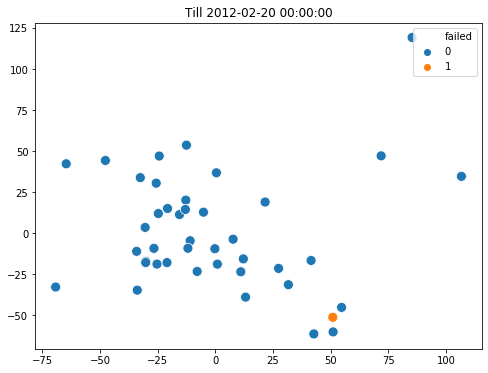

In [15]:
plot_ts(2)


Feature Extraction: 100%|██████████| 10/10 [02:42<00:00, 16.23s/it]


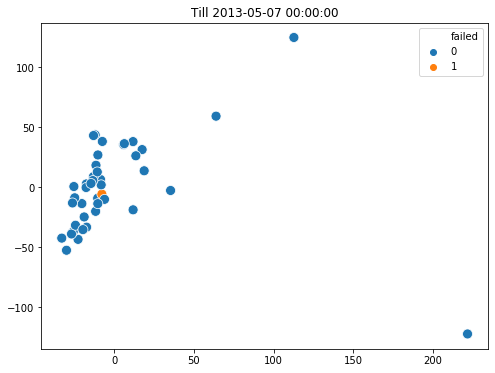

In [17]:
plot_ts(11)


Feature Extraction: 100%|██████████| 10/10 [01:36<00:00,  9.69s/it]


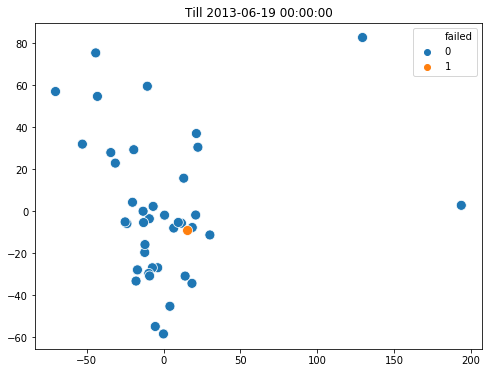

In [18]:
plot_ts(19)


Feature Extraction: 100%|██████████| 10/10 [01:34<00:00,  9.45s/it]


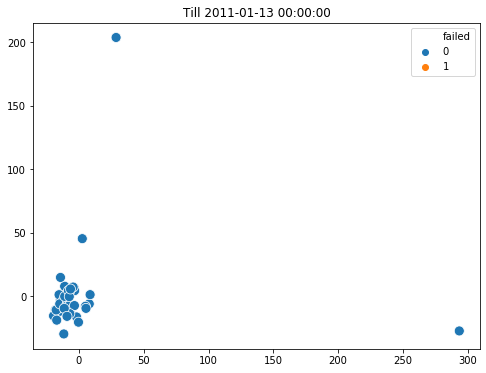

In [19]:
plot_ts(29)


Feature Extraction: 100%|██████████| 10/10 [01:34<00:00,  9.45s/it]


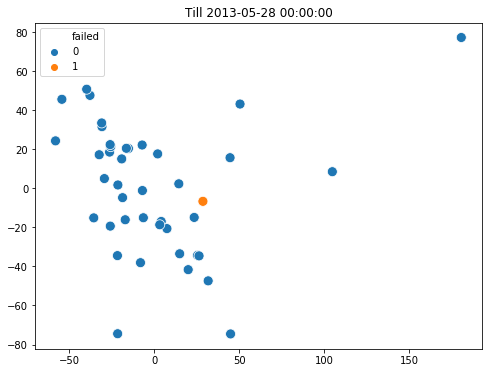

In [20]:
plot_ts(38)


Feature Extraction: 100%|██████████| 10/10 [01:38<00:00,  9.89s/it]


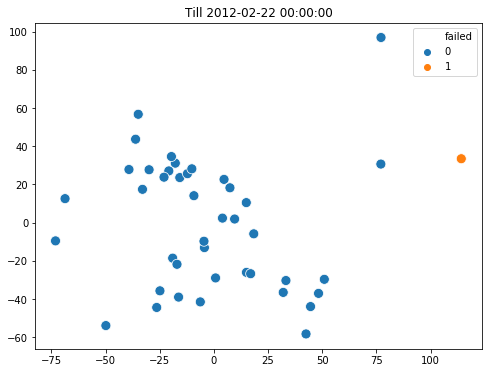

In [21]:
plot_ts(48)


Feature Extraction: 100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


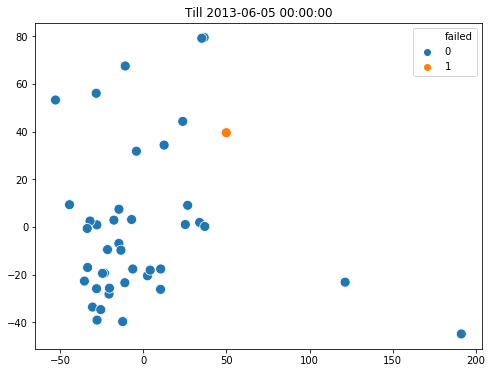

In [22]:
plot_ts(66)


Feature Extraction: 100%|██████████| 10/10 [01:39<00:00,  9.96s/it]


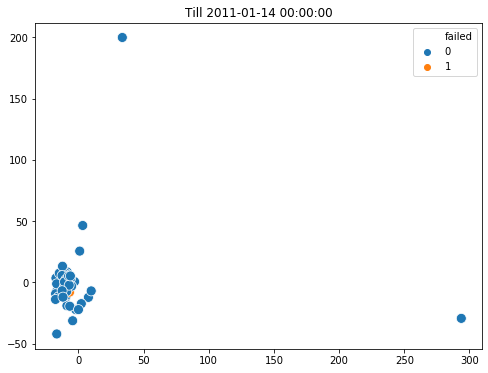

In [23]:
plot_ts(70)


Feature Extraction: 100%|██████████| 10/10 [01:38<00:00,  9.85s/it]


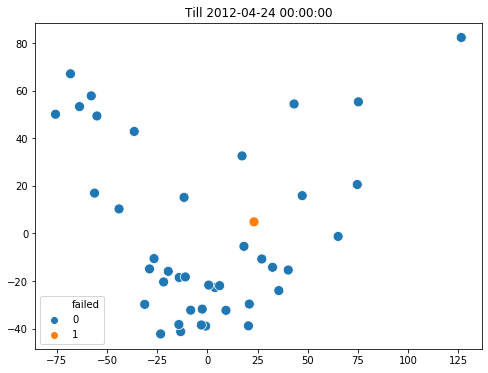

In [24]:
plot_ts(79)


Feature Extraction: 100%|██████████| 10/10 [02:14<00:00, 13.49s/it]


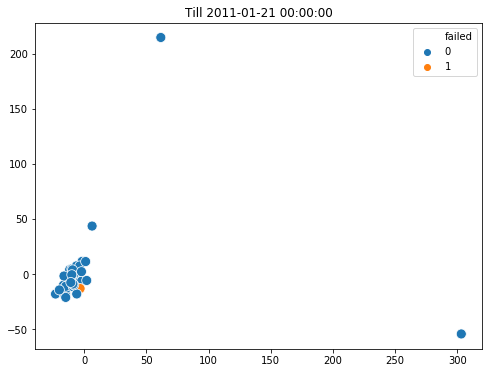

In [25]:
plot_ts(80)


Feature Extraction: 100%|██████████| 10/10 [02:07<00:00, 12.73s/it]


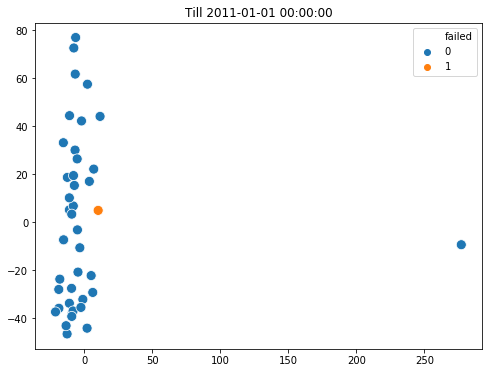

In [26]:
plot_ts(82)


Feature Extraction: 100%|██████████| 10/10 [02:10<00:00, 13.01s/it]


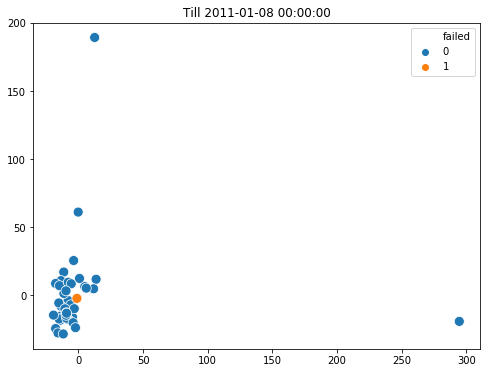

In [27]:
plot_ts(84)


Feature Extraction: 100%|██████████| 10/10 [02:10<00:00, 13.03s/it]


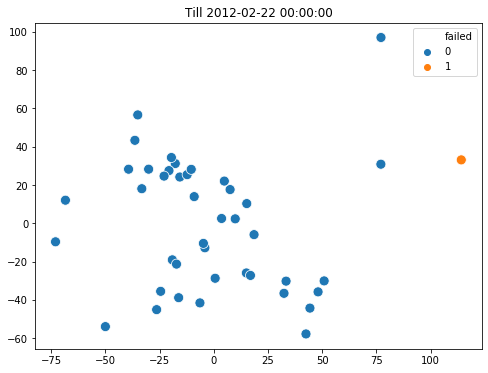

In [28]:
plot_ts(48)